Training model...
Training Episode 1/100, Reward: 578.00
Training Episode 2/100, Reward: 1677.00
Training Episode 3/100, Reward: 1511.00
Training Episode 4/100, Reward: 2384.00
Training Episode 5/100, Reward: 2037.00
Training Episode 6/100, Reward: 2372.00
Training Episode 7/100, Reward: 2122.00
Training Episode 8/100, Reward: 1962.00
Training Episode 9/100, Reward: 2273.00
Training Episode 10/100, Reward: 2170.00
Training Episode 11/100, Reward: 2381.00
Training Episode 12/100, Reward: 2443.00
Training Episode 13/100, Reward: 1836.00
Training Episode 14/100, Reward: 2274.00
Training Episode 15/100, Reward: 2304.00
Training Episode 16/100, Reward: 2413.00
Training Episode 17/100, Reward: 2738.00
Training Episode 18/100, Reward: 2383.00
Training Episode 19/100, Reward: 2442.00
Training Episode 20/100, Reward: 2322.00
Training Episode 21/100, Reward: 2254.00
Training Episode 22/100, Reward: 2219.00
Training Episode 23/100, Reward: 2224.00
Training Episode 24/100, Reward: 2136.00
Training

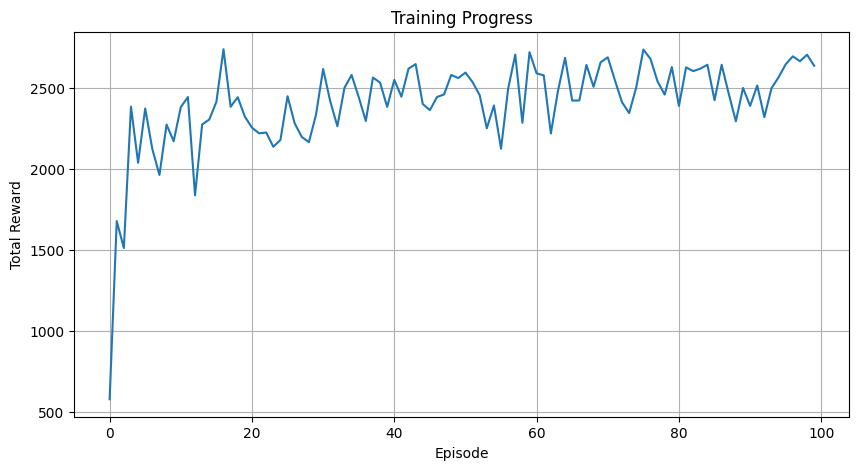

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("SUMO_HOME not found")

import traci

class RampMeteringEnv:
    def __init__(self, use_traffic_light=True):
        self.cfg_path = str(Path("D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"))
        self.sumoCmd = ["sumo", "-c", self.cfg_path, "--no-step-log", "--no-warnings"]
        self.use_traffic_light = use_traffic_light
        
        # Fixed lengths from SUMO network
        self.highway_length = 1000  # meters
        self.ramp_length = 100      # meters
        
        # Normalization constants
        self.MAX_DENSITY = 20.0
        self.MAX_QUEUE = 10.0
        self.MAX_SPEED = 13.89
        self.MAX_WAIT_TIME = 300.0
        
        # Q-learning parameters
        self.n_states = 4
        self.n_actions = 4
        self.q_table = {}
        
        # Network elements
        self.highway = "2to3"
        self.ramp = "intramp"
        self.tl_id = "node6"

    def start_simulation(self):
        try:
            traci.start(self.sumoCmd)
            return True
        except Exception as e:
            print(f"Error: {e}")
            return False

    def get_state(self):
        # Highway metrics (using fixed length)
        highway_density = traci.edge.getLastStepVehicleNumber(self.highway) / (self.highway_length/1000)
        highway_speed = traci.edge.getLastStepMeanSpeed(self.highway)
        
        # Ramp metrics
        ramp_queue = traci.edge.getLastStepHaltingNumber(self.ramp)
        ramp_speed = traci.edge.getLastStepMeanSpeed(self.ramp)
        
        # Normalize values
        norm_density = min(highway_density / self.MAX_DENSITY, 1.0)
        norm_queue = min(ramp_queue / self.MAX_QUEUE, 1.0)
        norm_highway_speed = min(highway_speed / self.MAX_SPEED, 1.0)
        norm_ramp_speed = min(ramp_speed / self.MAX_SPEED, 1.0)
        
        return tuple([norm_density, norm_queue, norm_highway_speed, norm_ramp_speed])

    def get_q_value(self, state, action=None):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        if action is None:
            return self.q_table[state]
        return self.q_table[state][action]

    def take_action(self, action):
        if not self.use_traffic_light:
            traci.simulationStep()
            return self.get_state(), self.calculate_reward(), False
            
        green_times = [5, 10, 15, 20]
        try:
            traci.trafficlight.setPhaseDuration(self.tl_id, green_times[action])
            
            # Simulate for green time duration
            for _ in range(green_times[action]):
                if traci.simulation.getMinExpectedNumber() <= 0:
                    return self.get_state(), 0, True
                traci.simulationStep()
            
            return self.get_state(), self.calculate_reward(), False
        except:
            return self.get_state(), 0, True

    def calculate_reward(self):
        waiting_time = (traci.edge.getWaitingTime(self.highway) + 
                     traci.edge.getWaitingTime(self.ramp))
        
        vehicles = (traci.edge.getLastStepVehicleNumber(self.highway) + 
                   traci.edge.getLastStepVehicleNumber(self.ramp))
        
        return (-waiting_time + vehicles * 10)
def train_model(episodes=500):
    alpha = 0.1
    gamma = 0.99
    epsilon = 0.1
    env = RampMeteringEnv(use_traffic_light=True)
    results = []
    
    for episode in range(episodes):
        if not env.start_simulation():
            continue
            
        state = env.get_state()
        total_reward = 0
        
        while True:
            action = (np.random.randint(env.n_actions) if np.random.random() < epsilon 
                     else np.argmax(env.get_q_value(state)))
            
            next_state, reward, done = env.take_action(action)
            total_reward += reward
            
            best_next = np.max(env.get_q_value(next_state))
            env.q_table[state][action] += alpha * (reward + gamma * best_next - 
                                                 env.q_table[state][action])
            
            state = next_state
            if done:
                break

        traci.close()
        results.append(total_reward)
        print(f"Training Episode {episode+1}/{episodes}, Reward: {total_reward:.2f}")
    
    # Save trained model
    np.save('trained_q_table.npy', env.q_table)
    
    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(results)
    plt.title('Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.savefig('training_progress.png')
    plt.show()
# Training phase
print("Training model...")
train_results = train_model(episodes=100)

Training model...
Episode 1/50 - Total Reward: 8816
Episode 2/50 - Total Reward: 10380
Episode 3/50 - Total Reward: 10566
Episode 4/50 - Total Reward: 10202
Episode 5/50 - Total Reward: 10326
Episode 6/50 - Total Reward: 11038
Episode 7/50 - Total Reward: 10568
Episode 8/50 - Total Reward: 10468
Episode 9/50 - Total Reward: 10468
Episode 10/50 - Total Reward: 10756
Episode 11/50 - Total Reward: 10652
Episode 12/50 - Total Reward: 10734
Episode 13/50 - Total Reward: 10352
Episode 14/50 - Total Reward: 10714
Episode 15/50 - Total Reward: 10714
Episode 16/50 - Total Reward: 10280
Episode 17/50 - Total Reward: 10710
Episode 18/50 - Total Reward: 10582
Episode 19/50 - Total Reward: 10656
Episode 20/50 - Total Reward: 10622
Episode 21/50 - Total Reward: 10582
Episode 22/50 - Total Reward: 10616
Episode 23/50 - Total Reward: 10616
Episode 24/50 - Total Reward: 10698
Episode 25/50 - Total Reward: 10708
Episode 26/50 - Total Reward: 10274
Episode 27/50 - Total Reward: 10436
Episode 28/50 - Tota

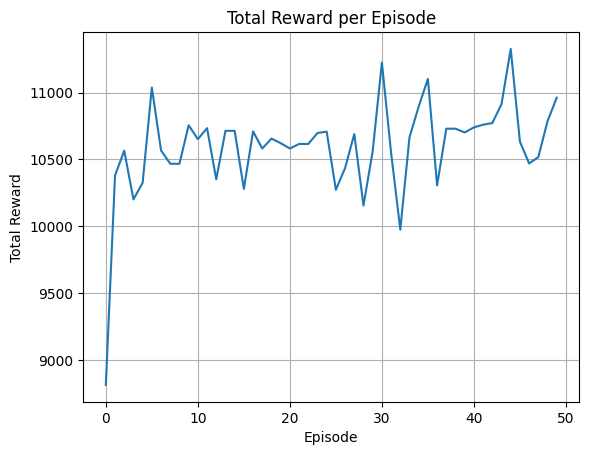

In [2]:
import os
import numpy as np
import traci
import matplotlib.pyplot as plt

# Q-Learning Parameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.9  # Discount factor
EPSILON = 0.1  # Exploration-exploitation balance
EPSILON_DECAY = 0.99
MIN_EPSILON = 0.01
MAX_EPISODES = 50
MAX_STEPS = 1000
NUM_ACTIONS = 4  # Number of actions (e.g., 0: 200, 1: 400, 2: 600, 3: 800)

# Environment Setup
SUMO_CMD = ["sumo", "-c", "D:/3CS/RL/rl for ramp metering/sumo/mynet.sumocfg"]

# State representation function
def get_state():
    highway_density = traci.edge.getLastStepVehicleNumber("2to3")
    ramp_queue = traci.edge.getLastStepHaltingNumber("intramp")
    return (highway_density, ramp_queue)

# Discretize state space (example)
def discretize_state(highway_density, ramp_queue):
    highway_bucket = min(highway_density // 5, 19)  # Increase granularity
    ramp_bucket = min(ramp_queue // 1, 19)  # Increase granularity
    return highway_bucket * 20 + ramp_bucket

# Reward function
def compute_reward(highway_density, ramp_queue):
    throughput = traci.edge.getLastStepVehicleNumber("2to3") * 10
    waiting_penalty = ramp_queue * 2
    return throughput - waiting_penalty  # Reward throughput, penalize queue

# Step function to advance the simulation
def step_simulation(action):
    flow_rates = [200, 400, 600, 800]
    traci.edge.setMaxSpeed("intramp", flow_rates[action]/3600)
    
    traci.simulationStep()
    highway_density = traci.edge.getLastStepVehicleNumber("2to3")
    ramp_queue = traci.edge.getLastStepHaltingNumber("intramp")
    next_state = discretize_state(highway_density, ramp_queue)
    reward = compute_reward(highway_density, ramp_queue)
    done = traci.simulation.getMinExpectedNumber() == 0

    return next_state, reward, done

# Training loop
def train_q_learning():
    Q_table = np.zeros((400, NUM_ACTIONS))  # State-action space with 400 discrete states
    rewards_per_episode = []

    for episode in range(MAX_EPISODES):
        traci.start(SUMO_CMD)
        state = discretize_state(*get_state())
        total_reward = 0

        global EPSILON
        for step in range(MAX_STEPS):
            if np.random.uniform(0, 1) < EPSILON:
                action = np.random.randint(0, NUM_ACTIONS)  # Explore
            else:
                action = np.argmax(Q_table[state])  # Exploit

            next_state, reward, done = step_simulation(action)
            total_reward += reward

            # Q-Learning update rule
            Q_table[state, action] = Q_table[state, action] + ALPHA * (
                reward + GAMMA * np.max(Q_table[next_state]) - Q_table[state, action]
            )

            state = next_state
            if done:
                break

        rewards_per_episode.append(total_reward)
        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)  # Decay epsilon
        print(f"Episode {episode + 1}/{MAX_EPISODES} - Total Reward: {total_reward}")
        traci.close()

    np.save("trained_with_no_traffic_light_q_table.npy", Q_table)
    return rewards_per_episode  # Return rewards_per_episode

# Visualization: Total Reward per Episode
def plot_rewards(rewards_per_episode):
    plt.figure()
    plt.plot(range(MAX_EPISODES), rewards_per_episode)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode")
    plt.grid(True)
    plt.savefig('training_with_no_traffic_light_progress.png')
    plt.show()

# Training phase
print("Training model...")
rewards_per_episode = train_q_learning()
plot_rewards(rewards_per_episode)